In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [101]:
# First, let's make some mock pareto sets
pf1 = np.array([
    [0.1, 0.9],
    [0.15, 0.88],
    [0.22, 0.7],
    [0.3, 0.6],
    [0.38, 0.56],
    [0.42, 0.55],
    [0.5, 0.5],
    [0.6, 0.4],
    [0.7, 0.2],
    [0.9, 0.1],
    [0.98, 0.06],
])
pf2 = np.array([
    [0.05, 0.95],
    [0.2, 0.88],
    [0.25, 0.85],
    [0.3, 0.6],
    [0.4, 0.5],
    [0.7, 0.3],
    [0.9, 0.02]
])
pf3 = np.array([
    [0.07, 0.98],
    [0.15, 0.9],
    [0.2, 0.8],
    [0.3, 0.75],
    [0.45, 0.7],
    [0.65, 0.48],
    [0.82, 0.22],
    [0.93, 0.2],
])
# If we need to, we can sort data in this format like this:
np.random.shuffle(pf1)
pf1 = pf1[pf1[:,0].argsort()]
pf1


array([[0.1 , 0.9 ],
       [0.15, 0.88],
       [0.22, 0.7 ],
       [0.3 , 0.6 ],
       [0.38, 0.56],
       [0.42, 0.55],
       [0.5 , 0.5 ],
       [0.6 , 0.4 ],
       [0.7 , 0.2 ],
       [0.9 , 0.1 ],
       [0.98, 0.06]])

In [103]:
# Store all of them in a list.
# Each set may have a different size, and numpy arrays cannot be jagged
# Therefore, we collect them in a list instead of an np array
pareto_sets = [pf1, pf2, pf3]

In [104]:
# Let's define a function for getting the line segments
# of the attainment surface
def attainment_lines(pareto_set, x_max, y_max):
    n_points = pareto_set.shape[0]
    
    # Each line segment is defined by a 2x2 array:
    # [[x1, y1], [x2, y2]]
    lines = np.empty((n_points * 2, 2, 2))

    # Collect all horizontal lines in the odd indices
    for i in range(n_points - 1):
        idx = 2 * i + 1
        start = pareto_set[i][0]
        stop = pareto_set[i + 1][0]
        y = pareto_set[i][1]
        lines[idx, :, 0] = start, stop
        lines[idx, :, 1] = y

    # And put the vertical line segments in the even indices.
    for i in range(n_points - 1):
        idx = 2 * i + 2
        start = pareto_set[i][1]
        stop = pareto_set[i + 1][1]
        x = pareto_set[i + 1][0]
        lines[idx, :, 0] = x
        lines[idx, :, 1] = start, stop
        
    # Finally, draw the line segments from the most extreme points
    # to the edges of the graph
    lines[0] = np.array([pareto_set[0,0], y_max,
                         pareto_set[0,0], pareto_set[0,1]]).reshape((2, 2))
    lines[-1] = np.array([pareto_set[-1, 0], pareto_set[-1, 1],
                          x_max, pareto_set[-1, 1]]).reshape((2, 2))
    return lines

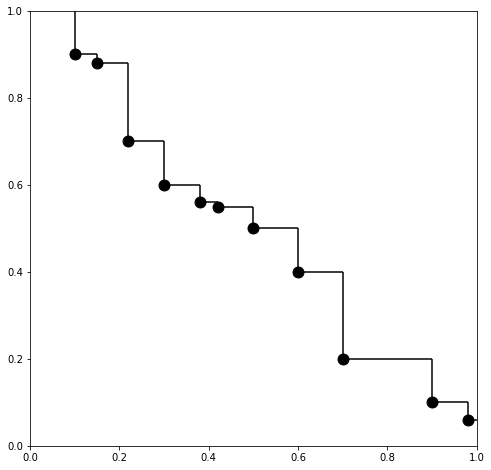

In [110]:
# Let's look at the attainment surface of the first pareto set
x_max = 1.0
y_max = 1.0
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.set_xlim(0, x_max)
axs.set_ylim(0, y_max)
collection = LineCollection(attainment_lines(pareto_sets[0], x_max, y_max), color='k')
axs.add_collection(collection)
axs.scatter(x=pareto_sets[0][:,0], y=pareto_sets[0][:,1], color='k', s=120)

# axs[1].set_xlim(0, x_max)
# axs[1].set_ylim(0, y_max)
# colors=['blue', 'red', 'green']
# for i in range(3):
#     collection = LineCollection(attainment_lines(pareto_sets[i], x_max, y_max), color=colors[i])
#     axs[1].add_collection(collection)
#     axs[1].scatter(x=pareto_sets[i][:,0], y=pareto_sets[i][:,1], color=colors[i], s=120)

plt.show()

In [ ]:
# Let's look at the attainment surface of the first pareto set
x_max = 1.0
y_max = 1.0
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_xlim(0, x_max)
axs[0].set_ylim(0, y_max)
collection = LineCollection(attainment_lines(pareto_sets[0], x_max, y_max), color='blue')
axs[0].add_collection(collection)
axs[0].scatter(x=pareto_sets[0][:,0], y=pareto_sets[0][:,1], color='blue')

axs[1].set_xlim(0, x_max)
axs[1].set_ylim(0, y_max)
colors=['blue', 'red', 'green']
for i in range(3):
    collection = LineCollection(attainment_lines(pareto_sets[i], x_max, y_max), color=colors[i])
    axs[1].add_collection(collection)
    axs[1].scatter(x=pareto_sets[i][:,0], y=pareto_sets[i][:,1], color=colors[i])


plt.show()

In [70]:
# Calculate the point where a line 
# Returns a size 3 vector: [x, y, dist], where dist is the cartesian distance
# from the y-intercept to the intersection on the attainment surface.
# If the lines do not intersect, the result is [np.inf, np.inf, np.inf]
def get_intersect(attainment_lines, slope, intercept):
    copy = attainment_lines.copy()
    
    # Let x1, y1, x2, y2 be coordinates of the line segment
    # Let f(x) = mx + b.  If f(x1) <= y1, and f(x2) >= y2, the lines must have intersected
    # Once we've identified the line segment which hit, we can easily calculate the position
    # This assumes 0 < m < inf
    copy[:, :, 0] = (copy[:, :, 0] * slope) + intercept
    hit_left = copy[:, 0, 0] <= copy[:, 0, 1]
    hit_right = copy[:, 1, 0] >= copy[:, 1, 1]
    hit = attainment_lines[hit_left & hit_right]
    
    if hit.shape[0] == 0:
        return np.array([np.inf, np.inf, np.inf])
    
    # Take the first one.  There will only be multiple values if the line crossed
    # right at the corner of two line segments - in which case, either one works
    hit = hit[0]
    
    if hit[0,1] == hit[1,1]:
        # Y values are the same, so the segment is horizontal
        y = hit[0,1]
        x = (y - intercept) / slope
    elif hit[0,0] == hit[1,0]:
        # X values are the same, so it should be a vertical segment
        x = hit[0,0]
        y = (slope * x) + intercept
    y_intercept = np.array([0, intercept])
    dist = np.linalg.norm(np.array([x, y]) - y_intercept)
    return np.array([x, y, dist])


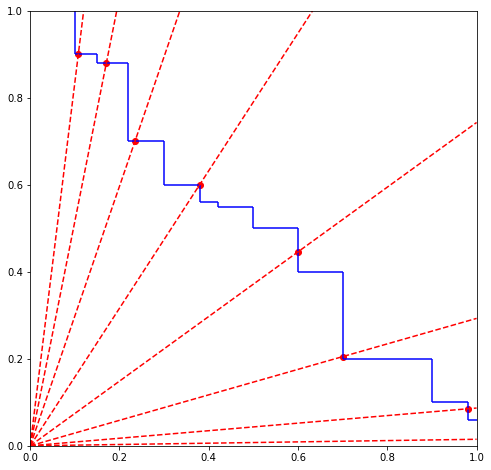

In [111]:
# If we draw various arbitrary lines with positive slopes, many of them will intersect with the attainment surface
x_max = 1.0
y_max = 1.0
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
collection = LineCollection(attainment_lines(pareto_sets[0], x_max, y_max), color='blue')
ax.add_collection(collection)
for slope in np.power(np.linspace(0.35, 1.7, 8), 4):
    ax.axline((0,0), slope=slope, linestyle='dashed', color='red')
    hit = get_intersect(attainment_lines(pareto_sets[0], x_max, y_max), slope, 0)
    if not np.isinf(hit[0]):
        ax.scatter(x=hit[0], y=hit[1], color='red')
plt.show()

Now suppose we have many pareto sets, representing different runs of the same algorithm. Any given line is going to cross through some or all of the attainment surfaces.

Imagine the line crosses through every surface: The last point it crosses through represents an objective-space vector whose solution was found in every single run.  Likewise, the corersponding solution for the first point crossed was only found in one solution.

We can take the median point for every line to achieve the median attainment surface.  We can also use this process to find the attainment surface for any other quantile.

If we use many lines, with various slopes and y-intercepts, we can get good coverage across all of the attainment surfaces.

Each dot represents where a line has intersected with the various attainment surfaces.

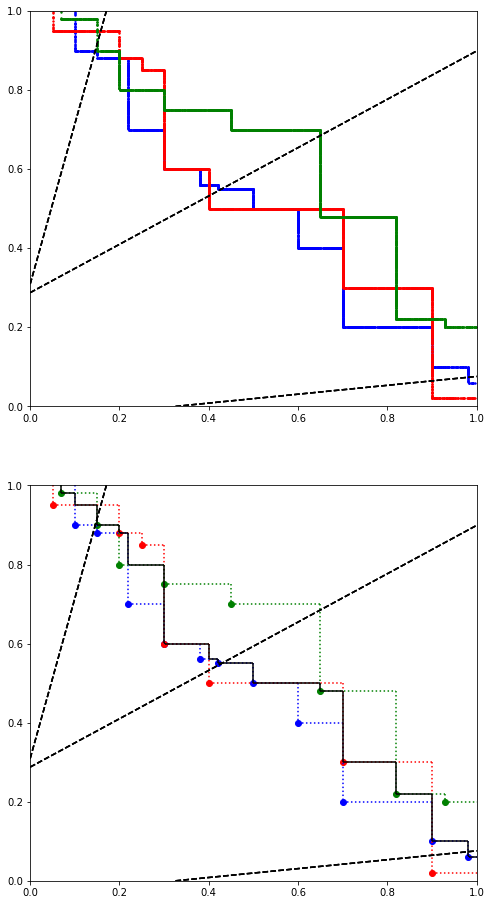

In [114]:
hits = np.empty((3000, 3, 3))
colors=['blue', 'red', 'green']
fig, ax = plt.subplots(2, 1, figsize=(8, 16))
ax[0].set_xlim(0, x_max)
ax[0].set_ylim(0, y_max)
for i in range(3):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, 20), 4):
        for x_shift in np.linspace(-0.2, 0.9, 10):
            for y_shift in np.linspace(-0.5, 0.85, 15):
                intercept = y_shift - x_shift * slope
                
                if hit_idx in [500, 1120, 2100]:
                    ax[0].axline((0, intercept), slope=slope, color='black', linestyle='dashed')
                    ax[1].axline((0, intercept), slope=slope, color='black', linestyle='dashed')
                                    
                hit = get_intersect(attainment_lines(pareto_sets[i], x_max, y_max), slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
    ax[0].scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i])
    ax[1].add_collection(LineCollection(attainment_lines(pareto_sets[i], 1.0, 1.0), color=colors[i], linestyle='dotted'))
    ax[1].scatter(x=pareto_sets[i][:,0], y=pareto_sets[i][:,1], color=colors[i])
    
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]
sort = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, False]).to_numpy()

lines = attainment_lines(sort, x_max, y_max)

ax[1].set_xlim(0, x_max)
ax[1].set_ylim(0, y_max)


collection = LineCollection(lines, color='black')
ax[1].add_collection(collection)


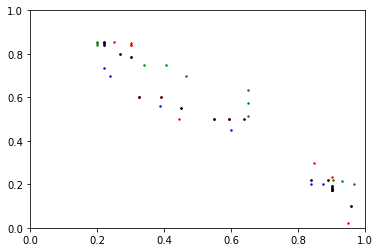

In [316]:
a, b, c = 3, 3, 3

hits = np.empty((a*b*c, 3, 3))
colors=['blue', 'red', 'green']
fig, ax = plt.subplots()
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
for i in range(3):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope
#                 if hit_idx == 1100:
#                     plt.axline((0, intercept), slope=slope, color='black', linestyle='dashed')
#                     print(slope)
#                     print(intercept)
                
                hit = get_intersect(attainment_lines(pareto_sets[i], x_max, y_max), slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i])
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]
ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color='black')

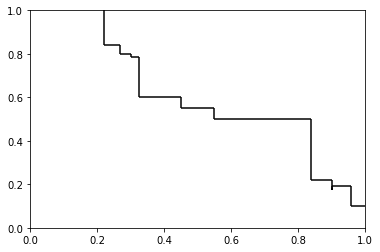

In [311]:
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]

sorty = non_null[non_null[:,0].argsort()][:,:2]

lines = attainment_lines(sorty, x_max, y_max)

fig, ax = plt.subplots()
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)


collection = LineCollection(lines, color='black')
ax.add_collection(collection)


In [331]:
sorty

array([[0.22      , 0.85630262],
       [0.22      , 0.84804919],
       [0.22      , 0.83979575],
       [0.26800033, 0.8       ],
       [0.3       , 0.78322654],
       [0.32618503, 0.6       ],
       [0.39048544, 0.6       ],
       [0.45002286, 0.55      ],
       [0.54880053, 0.5       ],
       [0.59336017, 0.5       ],
       [0.63791981, 0.5       ],
       [0.83998628, 0.22      ],
       [0.88913638, 0.22      ],
       [0.9       , 0.175     ],
       [0.9       , 0.175     ],
       [0.9       , 0.18325344],
       [0.9       , 0.175     ],
       [0.9       , 0.19150688],
       [0.95715592, 0.1       ]])

In [279]:
medians.shape

(3000, 3)

In [189]:
non_null.shape

(1543, 3)

In [200]:
non_null[:, :2]

array([[0.98      , 0.07966578],
       [0.82      , 0.22385422],
       [0.7       , 0.36810667],
       ...,
       [0.87226879, 0.22      ],
       [0.85850903, 0.22      ],
       [0.84474928, 0.22      ]])

In [204]:
def nondominated_set(array):
    pass

In [282]:
u, c = np.unique(medians[:,:2], return_counts=True, axis=0)
u[c > 1]

array([[0.9  , 0.175],
       [0.9  , 0.175],
       [  inf,   inf]])

In [284]:
aa = u[c > 1][0]
c

array([  1,   1,   1, ...,   1,   1, 622], dtype=int64)

In [285]:
np.where(medians[:,:2] == aa)

(array([   7,   22,   37,   52,   67,   82,   97,  112,  127,  142,  156,
         157,  171,  172,  186,  187,  201,  202,  217,  232,  247,  262,
         277,  292,  306,  321,  336,  351,  366,  367,  381,  382,  396,
         397,  412,  427,  442,  455,  456,  471,  486,  501,  516,  531,
         546,  547,  561,  562,  577,  592,  605,  620,  635,  650,  651,
         666,  681,  696,  711,  726,  727,  742,  753,  754,  769,  784,
         800,  815,  830,  831,  846,  861,  876,  877,  892,  902,  917,
         918,  933,  948,  949,  964,  980,  995, 1011, 1026, 1042, 1050,
        1066, 1081, 1082, 1097, 1113, 1129, 1144, 1145, 1160, 1176, 1192,
        1245, 1261, 1262, 1277, 1278, 1293, 1294, 1310, 1326, 1342, 1410,
        1426, 1442, 1443, 1459, 1475, 1476, 1492, 1591, 1608, 1625, 1642,
        1757, 1774, 1792, 1905, 1923, 1924, 1942, 1942, 2073, 2092, 2222,
        2242, 2242, 2370, 2371, 2392, 2392, 2542, 2542, 2692, 2692, 2842,
        2842, 2992], dtype=int64),
 ar

In [286]:
aa

array([0.9  , 0.175])

In [287]:
hits[7]

array([[0.9       , 0.19150688, 0.90010133],
       [0.9       , 0.19150688, 0.90010133],
       [       inf,        inf,        inf]])

In [289]:
hits[22]

array([[0.9       , 0.18967278, 0.90010133],
       [0.9       , 0.18967278, 0.90010133],
       [       inf,        inf,        inf]])

In [261]:
sint[49]

array([0.0016    , 0.79953778])

In [262]:
sint[149]

array([0.0065247 , 0.79811509])

In [235]:
sint[:2]

array([[0.0016, 0.0016],
       [0.0016, 0.0016]])

In [295]:
medians[(medians[:,0] > 0.17) & (medians[:,0] < .2)]

array([[0.19343304, 0.9       , 0.19669277],
       [0.19730878, 0.9       , 0.23125003],
       [0.19859193, 0.9       , 0.26079587],
       [0.17700864, 0.9       , 0.27052084],
       [0.17114407, 0.9       , 0.26155806],
       [0.19923105, 0.9       , 0.3650614 ],
       [0.18805522, 0.9       , 0.42080601],
       [0.19164426, 0.9       , 0.42883712],
       [0.1951067 , 0.9       , 0.53752151],
       [0.17661042, 0.9       , 0.48656402],
       [0.18614376, 0.9       , 0.5128285 ],
       [0.17205946, 0.9       , 0.58415921],
       [0.17539878, 0.9       , 0.59549653],
       [0.1787381 , 0.9       , 0.60683385],
       [0.18207741, 0.9       , 0.61817117],
       [0.19662069, 0.9       , 0.8198118 ],
       [0.17279832, 0.9       , 0.72048418],
       [0.19973104, 0.9       , 0.83278042],
       [0.17590866, 0.9       , 0.7334528 ],
       [0.17901901, 0.9       , 0.74642142],
       [0.18336371, 0.9       , 0.93350448],
       [0.18968204, 0.9       , 0.96567109],
       [0.

In [296]:
np.where(medians[:,1] == 0.9)

(array([ 629,  944, 1062, 1078, 1211, 1360, 1393, 1559, 1657, 1674, 1692,
        1709, 1804, 1805, 1823, 1841, 1859, 1952, 1971, 1990, 2009, 2118,
        2119, 2138, 2139, 2140, 2159, 2266, 2267, 2287, 2288, 2289, 2308,
        2309, 2415, 2435, 2436, 2437, 2458, 2459, 2583, 2584, 2585, 2586,
        2607, 2608, 2609, 2731, 2732, 2733, 2734, 2757, 2758, 2759, 2880,
        2881, 2882, 2883, 2906, 2907, 2908, 2909], dtype=int64),)

In [299]:
hits[629]

array([[0.15      , 0.89199275, 0.1525278 ],
       [0.2       , 0.90121068, 0.2033704 ],
       [0.19343304, 0.9       , 0.19669277]])

In [300]:
hits[944]

array([[0.15      , 0.89496765, 0.16304413],
       [0.2       , 0.91626812, 0.21739218],
       [0.16181276, 0.9       , 0.17588414]])

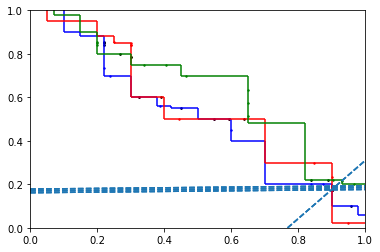

In [351]:
a, b, c = 3, 3, 3

hits = np.empty((a*b*c, 3, 3))
colors=['blue', 'red', 'green']
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [attainment_lines(i, 1.0, 1.0) for i in pareto_sets]

for i in range(3):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(attainment_lines(pareto_sets[i], x_max, y_max), slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                
                if hit_idx in [2, 5, 8, 17]:
                    ax.axline((0, intercept), slope=slope, linestyle='dashed')
                
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i])
    
    collection = LineCollection(lines[i], color=colors[i])
    ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]

ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color='black')

In [344]:
sorty

array([[0.22      , 0.85630262],
       [0.22      , 0.84804919],
       [0.22      , 0.83979575],
       [0.26800033, 0.8       ],
       [0.3       , 0.78322654],
       [0.32618503, 0.6       ],
       [0.39048544, 0.6       ],
       [0.45002286, 0.55      ],
       [0.54880053, 0.5       ],
       [0.59336017, 0.5       ],
       [0.63791981, 0.5       ],
       [0.83998628, 0.22      ],
       [0.88913638, 0.22      ],
       [0.9       , 0.175     ],
       [0.9       , 0.175     ],
       [0.9       , 0.18325344],
       [0.9       , 0.175     ],
       [0.9       , 0.19150688],
       [0.95715592, 0.1       ]])

In [352]:
non_null

array([[ 0.9       ,  0.19150688,  0.90010133],
       [ 0.22      ,  0.85630262,  0.22002477],
       [ 0.9       ,  0.18325344,  0.90010133],
       [ 0.22      ,  0.84804919,  0.22002477],
       [ 0.9       ,  0.175     ,  0.90010133],
       [ 0.22      ,  0.83979575,  0.22002477],
       [ 0.54880053,  0.5       ,  0.91560553],
       [ 0.26800033,  0.8       ,  0.44712527],
       [ 0.88913638,  0.22      ,  1.48341363],
       [ 0.59336017,  0.5       ,  0.98994775],
       [ 0.3       ,  0.78322654,  0.50051274],
       [ 0.9       ,  0.175     ,  1.50153822],
       [ 0.63791981,  0.5       ,  1.06428998],
       [ 0.45002286,  0.55      ,  4.74554615],
       [ 0.39048544,  0.6       ,  4.11771679],
       [ 0.32618503,  0.6       ,  3.43966109],
       [ 0.95715592,  0.1       , 10.09332632],
       [ 0.9       ,  0.175     ,  9.49061013],
       [ 0.83998628,  0.22      ,  8.85775814]])

In [378]:
sorty = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, False]).to_numpy()

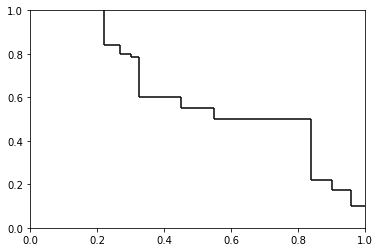

In [380]:
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]

lines = attainment_lines(sorty[:,:2], x_max, y_max)

fig, ax = plt.subplots()
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)


collection = LineCollection(lines, color='black')
ax.add_collection(collection)


In [379]:
sorty

array([[ 0.22      ,  0.85630262,  0.22002477],
       [ 0.22      ,  0.84804919,  0.22002477],
       [ 0.22      ,  0.83979575,  0.22002477],
       [ 0.26800033,  0.8       ,  0.44712527],
       [ 0.3       ,  0.78322654,  0.50051274],
       [ 0.32618503,  0.6       ,  3.43966109],
       [ 0.39048544,  0.6       ,  4.11771679],
       [ 0.45002286,  0.55      ,  4.74554615],
       [ 0.54880053,  0.5       ,  0.91560553],
       [ 0.59336017,  0.5       ,  0.98994775],
       [ 0.63791981,  0.5       ,  1.06428998],
       [ 0.83998628,  0.22      ,  8.85775814],
       [ 0.88913638,  0.22      ,  1.48341363],
       [ 0.9       ,  0.19150688,  0.90010133],
       [ 0.9       ,  0.18325344,  0.90010133],
       [ 0.9       ,  0.175     ,  9.49061013],
       [ 0.9       ,  0.175     ,  0.90010133],
       [ 0.9       ,  0.175     ,  1.50153822],
       [ 0.95715592,  0.1       , 10.09332632]])

In [432]:
sol = pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.11.16.08.11\\run0_slice0\\_experimentResults.txt", usecols=range(9)).append(
    pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.11.16.08.11\\run0_slice1\\_experimentResults.txt", usecols=range(9)), ignore_index=True
)

In [440]:
sol[['obj_0_tra','obj_2_tra']]

,obj_0_tra,obj_2_tra
0,0.000000,3.0
1,0.120487,20.0
2,0.000000,2.0
3,0.429433,2.0
4,0.429433,2.0
...,...,...
395,0.232134,2.0
396,0.078491,9.0
397,0.064804,2.0
398,0.034201,6.0


In [1]:
pf1

NameError: name 'pf1' is not defined

In [6]:
pf1

array([[0.1 , 0.9 ],
       [0.15, 0.88],
       [0.22, 0.7 ],
       [0.3 , 0.6 ],
       [0.38, 0.56],
       [0.42, 0.55],
       [0.5 , 0.5 ],
       [0.6 , 0.4 ],
       [0.7 , 0.2 ],
       [0.9 , 0.1 ],
       [0.98, 0.06]])

In [8]:
pt = pf1[0]
pt

array([0.1, 0.9])

In [11]:
mask = np.ones(pf1.shape[0], dtype=bool)
mask[0] = False
mask

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [12]:
others = pf1[mask]
others

array([[0.15, 0.88],
       [0.22, 0.7 ],
       [0.3 , 0.6 ],
       [0.38, 0.56],
       [0.42, 0.55],
       [0.5 , 0.5 ],
       [0.6 , 0.4 ],
       [0.7 , 0.2 ],
       [0.9 , 0.1 ],
       [0.98, 0.06]])

In [19]:
np.any((pt[0] > others[:,0]) & (pt[1] > others[:,1]))

False

In [21]:
def remove_dominated(arr):
    n_points = arr.shape[0]
    n_dim = arr.shape[1]
    
    dominated = np.zeros(n_points, dtype=bool)
    
    for i in range(n_points):
        pt = arr[i]
        
        # Get a view of 'arr', minus pt[i]
        mask = np.ones(n_points, dtype=bool)
        mask[i] = False
        others = arr[mask]
        
        # Domination (minimizatoin problem):
        # A <= B for all dimensions, and A < B for at least one dimension 
        better_or_equal_this = np.ones(n_points - 1, dtype=bool) # Track the "for all" condition
        better_than_this = np.zeros(n_points - 1, dtype=bool) # Track the "at least one" condition
        for dim in range(n_dim):
            better_or_equal_this = better_or_equal_this & (pt[dim] >= others[:,dim])
            better_than_this = better_than_this | (pt[dim] > others[:,dim])
        dominated[i] = np.any((better_or_equal_this & better_than_this))
        
    return arr[~dominated]

In [22]:
pts = np.random.random((100, 2))
ndom = remove_dominated(pts)

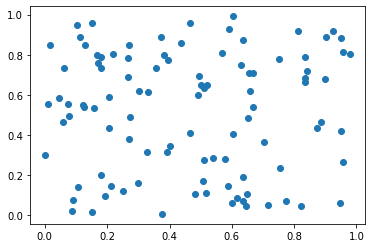

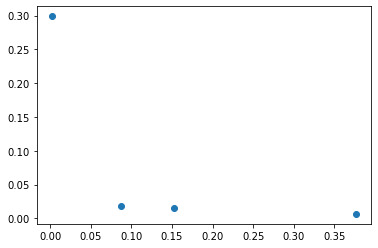

In [23]:
plt.scatter(x=pts[:,0], y=pts[:,1])
plt.show()
plt.scatter(x=ndom[:,0], y=ndom[:,1])
plt.show()

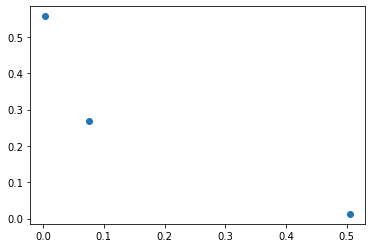

In [39]:
sol = pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.15.27.18\\run0_slice0\\_experimentResults.txt", usecols=range(9))
#C:\Users\ericv\code\research\RejectOption\results\2021.01.11.17.25.32
sol

,id,pareto_rank_tra,crowding_score_tra,obj_0_tra,obj_1_tra,obj_2_tra,obj_0_tst,obj_1_tst,obj_2_tst
0,0,1,inf,2.0,0.000000,664.0,2.0,0.000000,76.0
1,1,1,inf,2.0,0.000000,664.0,2.0,0.000000,76.0
2,2,1,inf,25.0,0.227207,0.0,25.0,0.285714,0.0
3,3,1,inf,2.0,0.347323,0.0,2.0,0.350649,0.0
4,4,1,inf,40.0,0.051903,402.0,40.0,0.212121,44.0
...,...,...,...,...,...,...,...,...,...
195,195,1,0.009966,10.0,0.155470,170.0,10.0,0.192982,20.0
196,196,1,0.009848,23.0,0.144177,150.0,23.0,0.241935,15.0
197,197,1,0.009492,19.0,0.103774,267.0,19.0,0.208333,29.0
198,198,1,0.008474,4.0,0.121813,338.0,4.0,0.205128,38.0


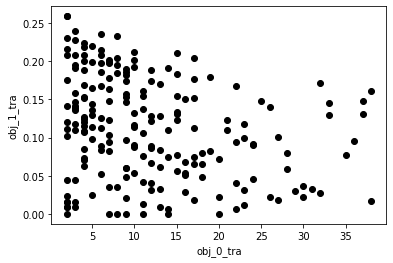

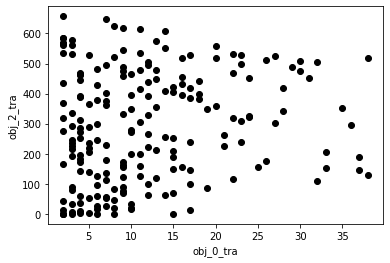

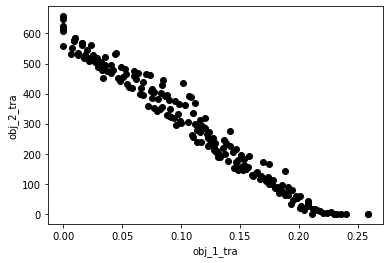

In [127]:
for i in range(3):
    for j in range(i + 1, 3):
        proj = sol[[sol.columns[3 + i], sol.columns[3 + j]]].to_numpy()
        #proj = remove_dominated(proj)
        fig, ax = plt.subplots()
        ax.plot(proj[:,0], proj[:,1], 'ok')
        ax.set_xlabel(sol.columns[3 + i])
        ax.set_ylabel(sol.columns[3 + j])
        plt.show()

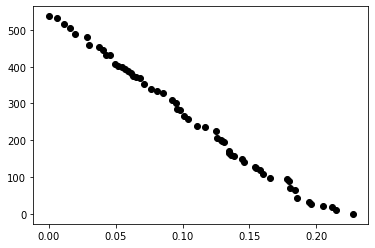

In [135]:
sol = pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.15.27.18\\run0_slice0\\_experimentResults.txt", usecols=range(9))
sol = sol[sol['pareto_rank_tra'] == 1]
proj = sol[['obj_1_tra', 'obj_2_tra']].sort_values(by=['obj_1_tra','obj_2_tra'], ascending=[True, True]).to_numpy()
proj = remove_dominated(proj)
plt.plot(proj[:,0], proj[:,1], 'ok')

In [60]:
lines = attainment_lines(proj, proj[:,0].max(), proj[:,1].max())
proj.shape

(59, 2)

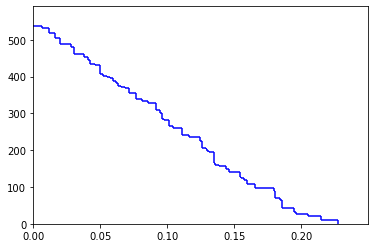

In [58]:
fig, ax = plt.subplots()
ax.set_xlim(0, proj[:,0].max() * 1.1)
ax.set_ylim(0, proj[:,1].max() * 1.1)
collection = LineCollection(lines, color='blue')
ax.add_collection(collection)

In [69]:
lines

array([[[0.00000000e+00, 4.69000000e+03],
        [0.00000000e+00, 4.69000000e+03]],

       [[0.00000000e+00, 4.69000000e+03],
        [0.00000000e+00, 4.69000000e+03]],

       [[0.00000000e+00, 4.69000000e+03],
        [0.00000000e+00, 4.59300000e+03]],

       [[0.00000000e+00, 4.59300000e+03],
        [2.39727312e-02, 4.59300000e+03]],

       [[2.39727312e-02, 4.59300000e+03],
        [2.39727312e-02, 3.82200000e+03]],

       [[2.39727312e-02, 3.82200000e+03],
        [2.91124968e-02, 3.82200000e+03]],

       [[2.91124968e-02, 3.82200000e+03],
        [2.91124968e-02, 3.66700000e+03]],

       [[2.91124968e-02, 3.66700000e+03],
        [3.10732340e-02, 3.66700000e+03]],

       [[3.10732340e-02, 3.66700000e+03],
        [3.10732340e-02, 3.65000000e+03]],

       [[3.10732340e-02, 3.65000000e+03],
        [3.27064850e-02, 3.65000000e+03]],

       [[3.27064850e-02, 3.65000000e+03],
        [3.27064850e-02, 3.08900000e+03]],

       [[3.27064850e-02, 3.08900000e+03],
        [3.3

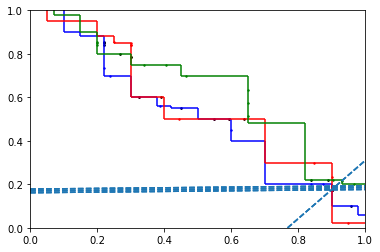

In [134]:
a, b, c = 3, 3, 3

hits = np.empty((a*b*c, 3, 3))
colors=['blue', 'red', 'green']
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [attainment_lines(i, 1.0, 1.0) for i in pareto_sets]

for i in range(3):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(attainment_lines(pareto_sets[i], x_max, y_max), slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                
                if hit_idx in [2, 5, 8, 17]:
                    ax.axline((0, intercept), slope=slope, linestyle='dashed')
                
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i])
    
    collection = LineCollection(lines[i], color=colors[i])
    ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
non_null = medians[~np.isinf(medians[:,0])]

ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color='black')

In [148]:
all_lines_tra_cl = []
for i in range(10):
    sol = pd.read_csv(
        "C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.15.27.18\\run0_slice{0}\\_experimentResults.txt".format(i),
                      usecols=range(9))
    sol = sol[sol['pareto_rank_tra'] == 1]
    proj = sol[['obj_1_tra', 'obj_2_tra']].sort_values(by=['obj_1_tra','obj_2_tra'], ascending=[True, True]).to_numpy()
    proj = remove_dominated(proj)
    proj[:,1] /= 691
    lines = attainment_lines(proj, proj[:,0].max(), proj[:,1].max())
    all_lines_tra_cl.append(lines)
    
a, b, c = 50, 50, 10

hits = np.empty((a*b*c, 10, 3))

for i in range(10):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(all_lines_tra_cl[i], slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
#    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i % 3])
    
#     collection = LineCollection(all_lines[i], color=colors[i % 3])
#     ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
medians = remove_dominated(medians)
non_null = medians[~np.isinf(medians[:,0])]
non_null = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, True]).to_numpy()
lines_final_tra_cl = attainment_lines(non_null, 1, 1)

In [149]:
all_lines_tst_cl = []
for i in range(10):
    sol = pd.read_csv(
        "C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.15.27.18\\run0_slice{0}\\_experimentResults.txt".format(i),
                      usecols=range(9))
    sol = sol[sol['pareto_rank_tra'] == 1]
    proj = sol[['obj_1_tst', 'obj_2_tst']].sort_values(by=['obj_1_tst','obj_2_tst'], ascending=[True, True]).to_numpy()
    proj = remove_dominated(proj)
    proj[:,1] /= 691
    proj[:,0] += 0.05
    lines = attainment_lines(proj, proj[:,0].max(), proj[:,1].max())
    all_lines_tst_cl.append(lines)
    
a, b, c = 50, 50, 10

hits = np.empty((a*b*c, 10, 3))

for i in range(10):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(all_lines_tst_cl[i], slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
#    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i % 3])
    
#     collection = LineCollection(all_lines[i], color=colors[i % 3])
#     ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
medians = remove_dominated(medians)
non_null = medians[~np.isinf(medians[:,0])]
non_null = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, True]).to_numpy()
lines_final_tst_cl = attainment_lines(non_null, 1, 1)

In [159]:
all_lines_tra_sv = []
for i in range(10):
    sol = pd.read_csv(
        "C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.20.04.40\\run0_slice{0}\\_experimentResults.txt".format(i),
                      usecols=range(9))
    sol = sol[sol['pareto_rank_tra'] == 1]
    proj = sol[['obj_1_tra', 'obj_2_tra']].sort_values(by=['obj_1_tra','obj_2_tra'], ascending=[True, True]).to_numpy()
    proj = remove_dominated(proj)
    proj[:,1] /= 691
    lines = attainment_lines(proj, proj[:,0].max(), proj[:,1].max())
    all_lines_tra_sv.append(lines)
    
a, b, c = 50, 50, 10

hits = np.empty((a*b*c, 10, 3))

for i in range(10):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(all_lines_tra_sv[i], slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
#    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i % 3])
    
#     collection = LineCollection(all_lines[i], color=colors[i % 3])
#     ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
medians = remove_dominated(medians)
non_null = medians[~np.isinf(medians[:,0])]
non_null = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, True]).to_numpy()
lines_final_tra_sv = attainment_lines(non_null, 1, 1)

In [160]:
all_lines_tst_sv = []
for i in range(10):
    sol = pd.read_csv(
        "C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.20.04.40\\run0_slice{0}\\_experimentResults.txt".format(i),
                      usecols=range(9))
    sol = sol[sol['pareto_rank_tra'] == 1]
    proj = sol[['obj_1_tst', 'obj_2_tst']].sort_values(by=['obj_1_tst','obj_2_tst'], ascending=[True, True]).to_numpy()
    proj = remove_dominated(proj)
    proj[:,1] /= 691
    proj[:,0] += 0.05
    lines = attainment_lines(proj, proj[:,0].max(), proj[:,1].max())
    all_lines_tst_sv.append(lines)
    
a, b, c = 50, 50, 10

hits = np.empty((a*b*c, 10, 3))

for i in range(10):
    hit_idx = 0
    for slope in np.power(np.linspace(0.35, 1.8, a), 4):
        for x_shift in np.linspace(-0.2, 0.9, b):
            for y_shift in np.linspace(-0.5, 0.85, c):
                intercept = y_shift - x_shift * slope                
                hit = get_intersect(all_lines_tst_sv[i], slope, intercept)
                hits[hit_idx,i] = hit
                hit_idx += 1
                            
    non_null = hits[:,i][~np.isinf(hits[:,i,0])]
#    ax.scatter(x=non_null[:,0], y=non_null[:,1], s=2, color=colors[i % 3])
    
#     collection = LineCollection(all_lines[i], color=colors[i % 3])
#     ax.add_collection(collection)
    
medians = np.median(hits, axis=1)
medians = remove_dominated(medians)
non_null = medians[~np.isinf(medians[:,0])]
non_null = pd.DataFrame(non_null).sort_values(by=[0,1], ascending=[True, True]).to_numpy()
lines_final_tst_sv = attainment_lines(non_null, 1, 1)

Text(0.5, 1.0, 'Pima Dataset, Training')

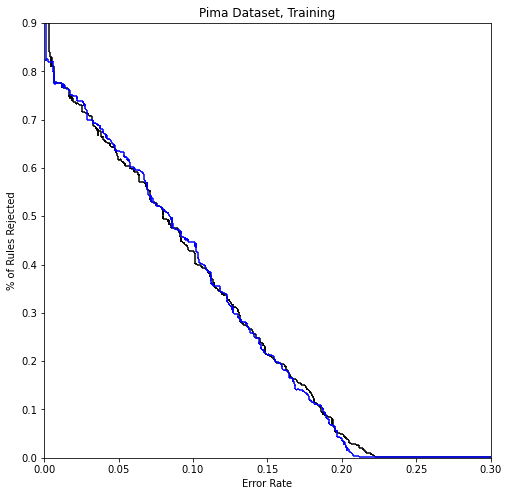

In [170]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0, 0.3)
ax.set_ylim(0, 0.9)

collection = LineCollection(lines_final_tra_cl, color='k')
ax.add_collection(collection)


collection = LineCollection(lines_final_tra_sv, color='blue')
ax.add_collection(collection)
ax.set_xlabel('Error Rate')
ax.set_ylabel('% of Rules Rejected')
ax.set_title('Pima Dataset, Training')


Text(0.5, 1.0, 'Pima Dataset, Testing')

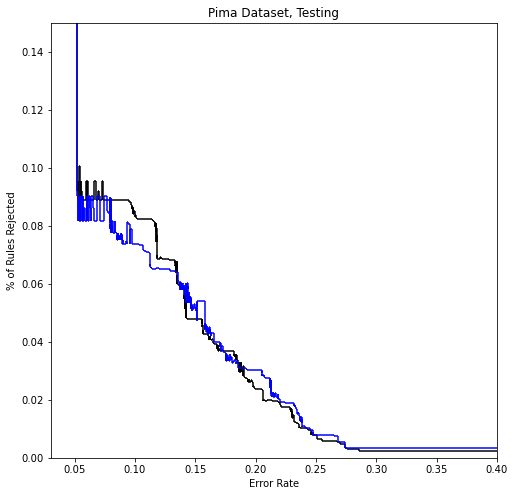

In [172]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(0.03, 0.4)
ax.set_ylim(0, 0.15)

collection = LineCollection(lines_final_tst_cl, color='k')
ax.add_collection(collection)


collection = LineCollection(lines_final_tst_sv, color='blue')
ax.add_collection(collection)
ax.set_xlabel('Error Rate')
ax.set_ylabel('% of Rules Rejected')
ax.set_title('Pima Dataset, Testing')

In [173]:
# Final calculation stuff
final_per_class = pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.16.52.47\\final.txt", usecols=range(6),
                             names=['tr_rules', 'tr_error', 'tr_rejected', 'ts_rules', 'ts_error', 'ts_rejected'])
final_sv = pd.read_csv("C:\\Users\\ericv\\code\\research\\RejectOption\\results\\2021.01.31.20.04.40\\final.txt", usecols=range(6),
                             names=['tr_rules', 'tr_error', 'tr_rejected', 'ts_rules', 'ts_error', 'ts_rejected'])

Text(0, 0.5, 'Number of rejected patterns')

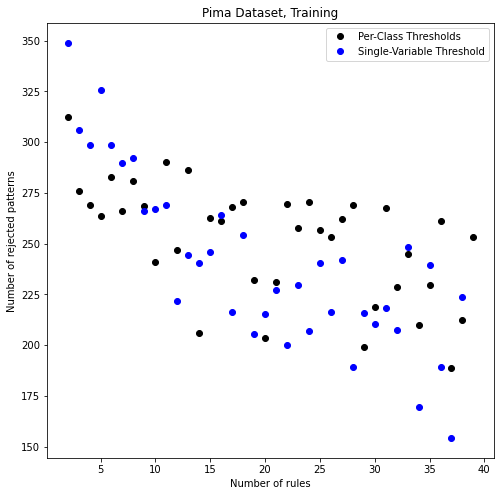

In [177]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(final_per_class['tr_rules'], final_per_class['tr_rejected'], 'ok', label='Per-Class Thresholds')
ax.plot(final_sv['tr_rules'], final_sv['tr_rejected'], 'ob', label='Single-Variable Threshold')

ax.legend()
ax.set_title('Pima Dataset, Training')
ax.set_xlabel('Number of rules')
ax.set_ylabel('Number of rejected patterns')

Text(0, 0.5, 'Number of rejected patterns')

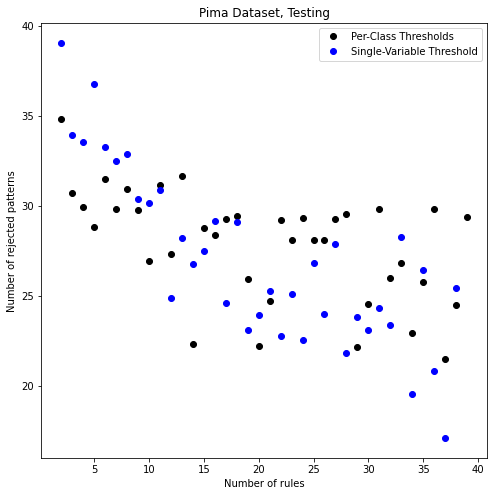

In [178]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(final_per_class['ts_rules'], final_per_class['ts_rejected'], 'ok', label='Per-Class Thresholds')
ax.plot(final_sv['ts_rules'], final_sv['ts_rejected'], 'ob', label='Single-Variable Threshold')

ax.legend()
ax.set_title('Pima Dataset, Testing')
ax.set_xlabel('Number of rules')
ax.set_ylabel('Number of rejected patterns')

Text(0, 0.5, 'Error rate')

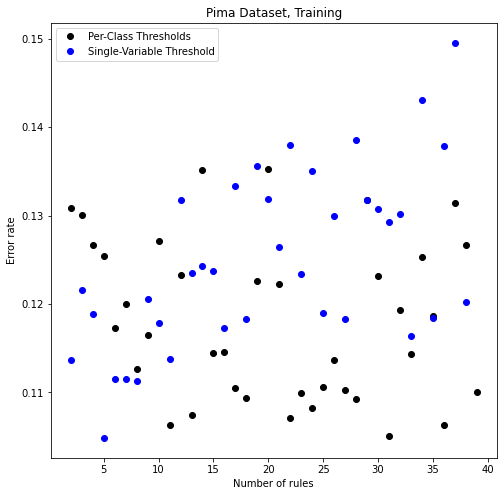

In [179]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(final_per_class['tr_rules'], final_per_class['tr_error'], 'ok', label='Per-Class Thresholds')
ax.plot(final_sv['tr_rules'], final_sv['tr_error'], 'ob', label='Single-Variable Threshold')

ax.legend()
ax.set_title('Pima Dataset, Training')
ax.set_xlabel('Number of rules')
ax.set_ylabel('Error rate')

Text(0, 0.5, 'Error rate')

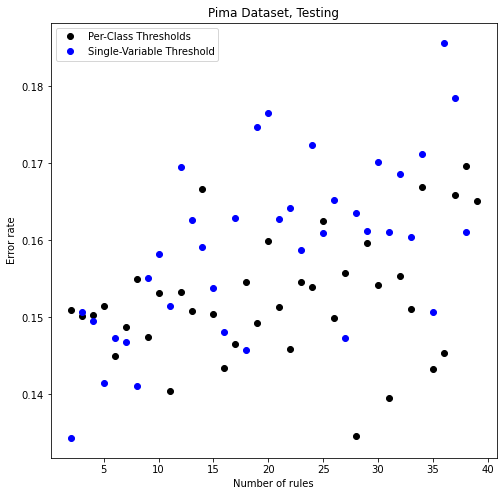

In [181]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(final_per_class['ts_rules'], final_per_class['ts_error'], 'ok', label='Per-Class Thresholds')
ax.plot(final_sv['ts_rules'], final_sv['ts_error'], 'ob', label='Single-Variable Threshold')

ax.legend()
ax.set_title('Pima Dataset, Testing')
ax.set_xlabel('Number of rules')
ax.set_ylabel('Error rate')